In [54]:
import torch
import torch.nn as nn

In [55]:
from lib.data import StonksDataset
from lib.modules import StockModule, StockTimeModule

In [56]:
class LSTMLoss(nn.Module):
    def __init__(self):
        super(LSTMLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.huber = nn.HuberLoss(reduction='sum', delta=1)

    def forward(self, pred, target):
        return self.mse(pred, target)

In [57]:
import pandas as pd

In [58]:
df = pd.read_csv('stock_market_data/forbes2000/csv/AAPL.csv').dropna(axis=0)

In [152]:
data = torch.from_numpy(df[['Adjusted Close', 'Open']].values).float()

In [153]:
data = (data - torch.min(data)) / (torch.max(data) - torch.min(data))

In [154]:
TIME = 60
EPOCHS = 100
DEVICE = 'cuda'

In [155]:
X = torch.stack([data[i:i + TIME] for i in range(data.shape[0] - TIME - 1) if not bool(torch.isnan(torch.sum(data[i:i + TIME])))])
y = torch.stack([data[i + TIME + 1] for i in range(data.shape[0] - TIME - 1) if not bool(torch.isnan(torch.sum(data[i + TIME + 1])))])

In [156]:
X.shape, y.shape

(torch.Size([10418, 60, 2]), torch.Size([10418, 2]))

In [157]:
class LSTMModel(nn.Module):
    def __init__(self, inputs: int, hidden: int, layers: int, outputs: int):
        super(LSTMModel, self).__init__()

        self.hidden = hidden
        self.outputs = outputs
        self.layers = layers
        self.inputs = inputs

        self.lstm = nn.LSTM(inputs, hidden, layers, batch_first=True)
        self.fc = nn.Linear(hidden, outputs)

    def forward(self, x: torch.Tensor):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layers, x.size(0), self.hidden).to(DEVICE).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.layers, x.size(0), self.hidden).to(DEVICE).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

In [158]:
m = LSTMModel(2, 30, 2, 2).to(DEVICE)
loss_fn = LSTMLoss().to(DEVICE)
opt = torch.optim.Adam(m.parameters(), lr=1e-2)

In [159]:
print(m)

LSTMModel(
  (lstm): LSTM(2, 30, num_layers=2, batch_first=True)
  (fc): Linear(in_features=30, out_features=2, bias=True)
)


In [160]:
from tqdm import tqdm

In [161]:
x = X.to(DEVICE)

for t in tqdm(range(EPOCHS), total=EPOCHS, leave=True):
    out = m(x)
    y_true = y

    loss = loss_fn(out, y_true.to(DEVICE))
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    

 16%|█▌        | 16/100 [00:00<00:03, 24.55it/s]

Epoch  10 MSE:  108.70228576660156


 25%|██▌       | 25/100 [00:01<00:02, 25.36it/s]

Epoch  20 MSE:  25.033676147460938


 34%|███▍      | 34/100 [00:01<00:02, 25.80it/s]

Epoch  30 MSE:  16.51978302001953


 46%|████▌     | 46/100 [00:01<00:02, 25.70it/s]

Epoch  40 MSE:  6.238804817199707


 55%|█████▌    | 55/100 [00:02<00:01, 25.53it/s]

Epoch  50 MSE:  3.4723448753356934


 64%|██████▍   | 64/100 [00:02<00:01, 25.74it/s]

Epoch  60 MSE:  2.71173095703125


 76%|███████▌  | 76/100 [00:03<00:00, 25.86it/s]

Epoch  70 MSE:  2.0917391777038574


 85%|████████▌ | 85/100 [00:03<00:00, 25.75it/s]

Epoch  80 MSE:  1.638960599899292


 94%|█████████▍| 94/100 [00:03<00:00, 25.78it/s]

Epoch  90 MSE:  1.3950364589691162


100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


In [162]:
y.shape, X[0].shape

(torch.Size([10418, 2]), torch.Size([60, 2]))

In [149]:
import matplotlib.pyplot as plt

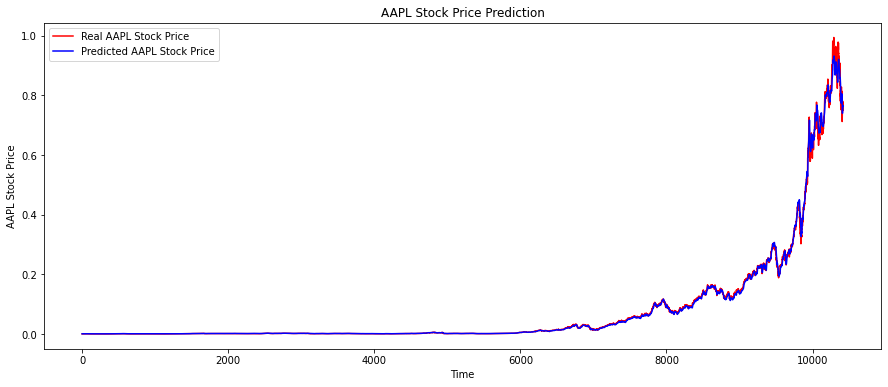

In [163]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))

axes.plot(y[:, 0], color = 'red', label = 'Real AAPL Stock Price')
axes.plot(m(X.to(DEVICE)).to('cpu').detach()[:, 0], color = 'blue', label = 'Predicted AAPL Stock Price')

plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()

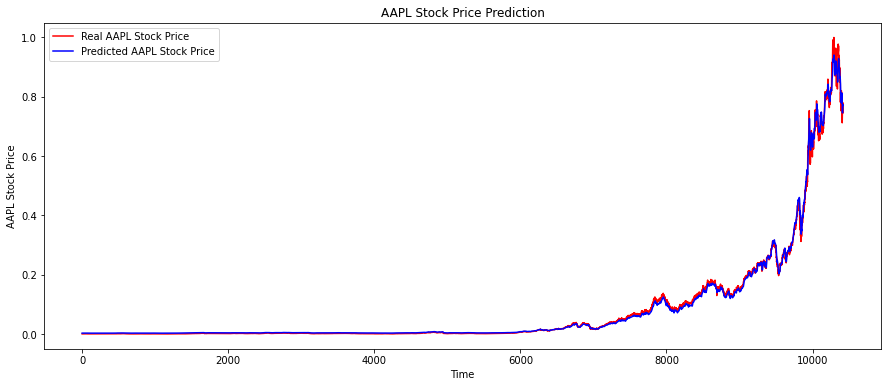

In [164]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))

axes.plot(y[:, 1], color = 'red', label = 'Real AAPL Stock Price')
axes.plot(m(X.to(DEVICE)).to('cpu').detach()[:, 1], color = 'blue', label = 'Predicted AAPL Stock Price')

plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()